In [13]:

from network import transformNet
from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet,DiscriminatorNet_feature
from functional import noise
#from train import train,eval_generate
import resnet


import invresnet
import matplotlib.pylab as plt

from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim

In [14]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [19]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
train_load,test_load=batchfy(batch_size=64)

In [21]:
show_img=iter(train_load)

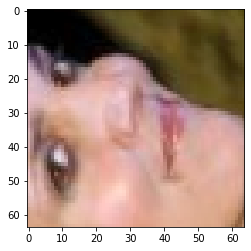

In [22]:
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [23]:
len(train_load)

2771

In [24]:
Encoder=resnet.resnet18()
Encoder.to(device)

Decoder=invresnet.invresnet18()
Decoder.to(device)

Generator=GeneratorNet(Encoder,Decoder)
Generator.to(device)
Discriminator_reconstruct=DiscriminatorNet_reconstruction(3,64)
Discriminator_reconstruct.to(device)

Discriminator_feature=DiscriminatorNet_feature()
Discriminator_feature.to(device)
print("model_loaded")

debug=torch.randn((1,99))
debug.to(device)
Decoder(debug).shape

model_loaded


torch.Size([1, 3, 64, 64])

In [25]:
dr_optimizer = optim.Adam(Discriminator_reconstruct.parameters(), lr=0.00005, betas=(0.5, 0.999))
df_optimizer = optim.Adam(Discriminator_feature.parameters(), lr=0.00005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(Generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
e_optimizer = optim.Adam(Encoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(Decoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
#print("modules Loaded")
num_epochs=40

In [26]:
import time
from torchvision import transforms, utils

In [29]:
def real_data_target(size):
    data = torch.ones(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    data = torch.zeros(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def real_feature_target(size):
    data = torch.ones(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_feature_target(size):
    data = torch.zeros(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def reconstruction_loss(optimizer,real_data,Generator):
    reconstruction=Generator(real_data)
    loss = nn.L1Loss()
    optimizer.zero_grad()
    error_recons=loss(real_data,reconstruction)*0.9
    error_recons.backward()
    optimizer.step()
    return error_recons
def adv_feature_loss(minimizing,real_feature,fake_feature,Discriminator,optimizer1,optimizer2):
    loss=nn.BCELoss()
    if minimizing:
        optimizer1.zero_grad()
        prediction_real = Discriminator(real_feature)
        error_real = loss(prediction_real, real_feature_target(real_feature.size(0)))
        error_real.backward()   
        
        prediction_fake = Discriminator(fake_feature)
        error_fake = loss(prediction_fake, fake_feature_target(real_feature.size(0)))
        error_fake.backward()
        total_error=error_real+error_fake
        optimizer1.step()    
        return error_real+error_fake
    else:
        optimizer2.zero_grad()
        prediction_fake=Discriminator(fake_feature)
        error_fake = loss(prediction_fake, real_feature_target(real_feature.size(0)))
        error_fake.backward()
        optimizer2.step()    
        return error_fake


def adv_img_loss(minimizing,real_data,fake_data,Discriminator,optimizer1,optimizer2):
    loss = nn.BCELoss()
    def dloss_calc_adv(optimizer, real_data, fake_data,Discriminator):
        
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake
    def gloss_calc_adv(optimizer, real_data,fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_fake=Discriminator(fake_data_target)
        error_fake = loss(prediction_fake, real_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
       
    if minimizing:
        return dloss_calc_adv(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc_adv(optimizer2,real_data,fake_data,Discriminator)
    
    
def gen_image_loss(minimizing,real_data, fake_data,Discriminator, optimizer1,optimizer2):
    def dloss_calc(optimizer, real_data, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake, prediction_real, prediction_fake
    def gloss_calc(optimizer, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction = Discriminator(fake_data)
        error = loss(prediction, real_data_target(prediction.size(0)))
        error.backward()
        optimizer.step()
        return error
    
    loss = nn.BCELoss()
        
    if minimizing:
        return dloss_calc(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc(optimizer2,fake_data,Discriminator)

def noise_vector(size):
    n = torch.randn(size,99)
    if torch.cuda.is_available(): return n.cuda() 
    return n

def eval_generate(Decoder,num_images):
    Decoder.eval()
    noi_input=noise_vector(num_images)
    output=Decoder(noi_input)
    output=output.detach().cpu()
    plt.figure(figsize=(16, 16))
    grid_border_size = 2
    grid = utils.make_grid(output)
    
    plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def train(num_epochs,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load):
    t_start = time.time()
    duration_avg = 0.0
    Encoder.train()
    Decoder.train()
    Generator.train()
    Discriminator_reconstruct.train()
    Discriminator_feature.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):        
 
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            noi = noise_vector(real_images.size(0))

            # 1-1.Train DiscriminatorX with img
            fake_data = Decoder(noi).detach()
            d_error, d_pred_real, d_pred_fake =gen_image_loss(True,real_images.float(), 
                                                              fake_data,Discriminator_reconstruct,
                                                              dr_optimizer,d_optimizer)
            # Train 1-2 GeneratorX
            fake_data = Decoder(noi)#noise(real_batch.size(0)))
            g_error = gen_image_loss(False, real_images.float(), fake_data,
                                    Discriminator_reconstruct,
                                    dr_optimizer,d_optimizer)

            #2 Train DiscriminatorZ
            real_feature=Encoder(real_images.float()).detach()
            df_error_adv=adv_feature_loss(True,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            real_feature=Encoder(real_images.float())
            en_error_adv=adv_feature_loss(False,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            #3-1 Train DiscriminatorX_adv
            
            fake_data=Generator(real_images.float()).detach()
            d_error1=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            #3-2 Train GeneratorX_adv
            fake_data=Generator(real_images.float())
            g_error2=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            # 4. Train Reconstruction
            
            recons_loss=reconstruction_loss(g_optimizer,real_images.float(),Generator)
            
            
            # Display Progress
            if (batch_i) % 150 == 0:
                print("Batch: ", batch_i)
                print("1:Discriminator_Error: ", d_error.item()," Generator_Error: ", g_error.item()," Recons_Error: ", recons_loss.item())
                print("2:Feature Discriminator Error: ",df_error_adv.item(),"Encoder Error: ", en_error_adv.item())
                print("3 Discriminator_adv_error", d_error1.item(), "Generator_error: ", g_error2.item())
            
    
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
        torch.save(Encoder,'Encoder_64batch.h')
        torch.save(Decoder,'Decoder_64batch.h')
        torch.save(Discriminator_feature,'Discriminator_feature_64batch.h')
        torch.save(Discriminator_reconstruct,'Discriminator_reconstruct_64batch.h')
        eval_generate(Decoder,8)
        

Epoch: 0
Batch:  0
1:Discriminator_Error:  1.3647533655166626  Generator_Error:  0.7268292903900146  Recons_Error:  0.4476111829280853
2:Feature Discriminator Error:  1.454769492149353 Encoder Error:  0.6978426575660706
3 Discriminator_adv_error 1.3324997425079346 Generator_error:  1.3228974342346191
Batch:  150
1:Discriminator_Error:  1.2952382564544678  Generator_Error:  0.6108510494232178  Recons_Error:  0.20902442932128906
2:Feature Discriminator Error:  1.391573190689087 Encoder Error:  0.6667749285697937
3 Discriminator_adv_error 0.8638527393341064 Generator_error:  0.8594735860824585
Batch:  300
1:Discriminator_Error:  1.4171619415283203  Generator_Error:  0.5563458800315857  Recons_Error:  0.1909133493900299
2:Feature Discriminator Error:  1.4600813388824463 Encoder Error:  0.6516565680503845
3 Discriminator_adv_error 0.9163268804550171 Generator_error:  0.9042924642562866
Batch:  450
1:Discriminator_Error:  1.4244996309280396  Generator_Error:  0.5282440185546875  Recons_Error

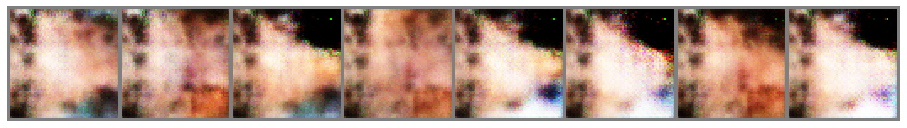

Epoch: 1
Batch:  0
1:Discriminator_Error:  1.307386875152588  Generator_Error:  0.557065486907959  Recons_Error:  0.1795802116394043
2:Feature Discriminator Error:  1.4010858535766602 Encoder Error:  0.707810640335083
3 Discriminator_adv_error 0.778488039970398 Generator_error:  0.7096798419952393
Batch:  150
1:Discriminator_Error:  0.1544310599565506  Generator_Error:  2.8324124813079834  Recons_Error:  0.83416348695755
2:Feature Discriminator Error:  1.3915029764175415 Encoder Error:  0.7114456295967102
3 Discriminator_adv_error 0.15383946895599365 Generator_error:  0.15489789843559265
Batch:  300
1:Discriminator_Error:  0.10934671759605408  Generator_Error:  3.0820555686950684  Recons_Error:  0.8678017854690552
2:Feature Discriminator Error:  1.397688627243042 Encoder Error:  0.7324575185775757
3 Discriminator_adv_error 0.10896273702383041 Generator_error:  0.1079733818769455
Batch:  450
1:Discriminator_Error:  1.3181127309799194  Generator_Error:  0.7486687898635864  Recons_Error: 

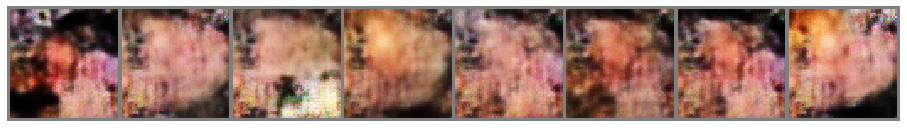

Epoch: 2
Batch:  0
1:Discriminator_Error:  1.4514309167861938  Generator_Error:  0.501923680305481  Recons_Error:  0.12005406618118286
2:Feature Discriminator Error:  1.3943899869918823 Encoder Error:  0.7094489932060242
3 Discriminator_adv_error 0.500093400478363 Generator_error:  0.43117183446884155
Batch:  150
1:Discriminator_Error:  1.4773858785629272  Generator_Error:  0.44760948419570923  Recons_Error:  0.10934703052043915
2:Feature Discriminator Error:  1.389972448348999 Encoder Error:  0.6933279633522034
3 Discriminator_adv_error 0.3662881553173065 Generator_error:  0.35884103178977966
Batch:  300
1:Discriminator_Error:  1.4874924421310425  Generator_Error:  0.45158541202545166  Recons_Error:  0.10465551167726517
2:Feature Discriminator Error:  1.3929307460784912 Encoder Error:  0.6999610662460327
3 Discriminator_adv_error 0.4084226191043854 Generator_error:  0.39095938205718994
Batch:  450
1:Discriminator_Error:  1.4871795177459717  Generator_Error:  0.5747567415237427  Recons

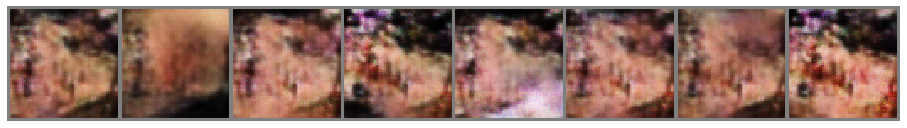

Epoch: 3
Batch:  0
1:Discriminator_Error:  1.58161199092865  Generator_Error:  0.5116832256317139  Recons_Error:  0.11009404808282852
2:Feature Discriminator Error:  1.3895130157470703 Encoder Error:  0.7041373252868652
3 Discriminator_adv_error 0.510658860206604 Generator_error:  0.4587760269641876
Batch:  150
1:Discriminator_Error:  1.4624156951904297  Generator_Error:  0.4242018759250641  Recons_Error:  0.11033026874065399
2:Feature Discriminator Error:  1.3959507942199707 Encoder Error:  0.6915465593338013
3 Discriminator_adv_error 0.32116395235061646 Generator_error:  0.31694257259368896
Batch:  300
1:Discriminator_Error:  1.567009687423706  Generator_Error:  0.3789547085762024  Recons_Error:  0.10312188416719437
2:Feature Discriminator Error:  1.3930718898773193 Encoder Error:  0.7046732902526855
3 Discriminator_adv_error 0.3219342529773712 Generator_error:  0.31691476702690125
Batch:  450
1:Discriminator_Error:  1.476453423500061  Generator_Error:  0.5933571457862854  Recons_Err

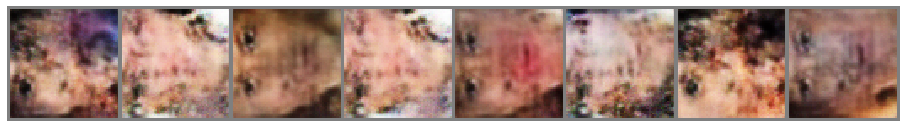

Epoch: 4
Batch:  0
1:Discriminator_Error:  1.5455549955368042  Generator_Error:  0.42847636342048645  Recons_Error:  0.10497920960187912
2:Feature Discriminator Error:  1.3890432119369507 Encoder Error:  0.6951779127120972
3 Discriminator_adv_error 0.3612046241760254 Generator_error:  0.3508716821670532
Batch:  150
1:Discriminator_Error:  1.5423429012298584  Generator_Error:  0.40582671761512756  Recons_Error:  0.09557213634252548
2:Feature Discriminator Error:  1.380568027496338 Encoder Error:  0.6936901211738586
3 Discriminator_adv_error 0.3112082779407501 Generator_error:  0.30626368522644043
Batch:  300
1:Discriminator_Error:  1.9079138040542603  Generator_Error:  0.3808239698410034  Recons_Error:  0.09954623878002167
2:Feature Discriminator Error:  1.3903239965438843 Encoder Error:  0.685588538646698
3 Discriminator_adv_error 0.7141126394271851 Generator_error:  0.8625571727752686
Batch:  450
1:Discriminator_Error:  1.6221059560775757  Generator_Error:  0.36771470308303833  Recons

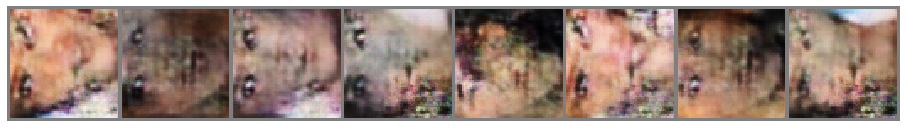

Epoch: 5
Batch:  0
1:Discriminator_Error:  1.6207550764083862  Generator_Error:  0.5170313119888306  Recons_Error:  0.10286471992731094
2:Feature Discriminator Error:  1.3891702890396118 Encoder Error:  0.6892846822738647
3 Discriminator_adv_error 0.36943888664245605 Generator_error:  0.3151589632034302
Batch:  150
1:Discriminator_Error:  1.6067824363708496  Generator_Error:  0.38029950857162476  Recons_Error:  0.09124010801315308
2:Feature Discriminator Error:  1.3877253532409668 Encoder Error:  0.6984302997589111
3 Discriminator_adv_error 0.35879361629486084 Generator_error:  0.34942179918289185
Batch:  300
1:Discriminator_Error:  1.5705931186676025  Generator_Error:  0.3826901912689209  Recons_Error:  0.09489281475543976
2:Feature Discriminator Error:  1.385596752166748 Encoder Error:  0.6989829540252686
3 Discriminator_adv_error 0.31041964888572693 Generator_error:  0.30331310629844666
Batch:  450
1:Discriminator_Error:  1.5048134326934814  Generator_Error:  0.4860510230064392  Rec

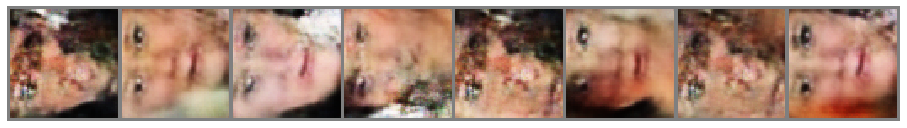

Epoch: 6
Batch:  0
1:Discriminator_Error:  1.5903849601745605  Generator_Error:  0.40474244952201843  Recons_Error:  0.09291024506092072
2:Feature Discriminator Error:  1.386387586593628 Encoder Error:  0.7030534148216248
3 Discriminator_adv_error 0.356771856546402 Generator_error:  0.3346283435821533
Batch:  150
1:Discriminator_Error:  1.6901013851165771  Generator_Error:  0.3502253293991089  Recons_Error:  0.08761732280254364
2:Feature Discriminator Error:  1.38462495803833 Encoder Error:  0.6987528800964355
3 Discriminator_adv_error 0.36792823672294617 Generator_error:  0.34426096081733704
Batch:  300
1:Discriminator_Error:  1.6189188957214355  Generator_Error:  0.3519427180290222  Recons_Error:  0.08803723007440567
2:Feature Discriminator Error:  1.3859522342681885 Encoder Error:  0.6975362300872803
3 Discriminator_adv_error 0.3325391411781311 Generator_error:  0.3273651599884033
Batch:  450
1:Discriminator_Error:  1.38779878616333  Generator_Error:  0.4977250099182129  Recons_Erro

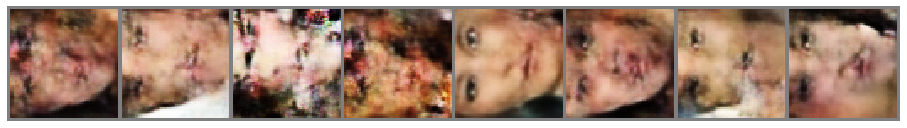

Epoch: 7
Batch:  0
1:Discriminator_Error:  1.5733373165130615  Generator_Error:  0.3818328380584717  Recons_Error:  0.08890905976295471
2:Feature Discriminator Error:  1.387798547744751 Encoder Error:  0.6877318620681763
3 Discriminator_adv_error 0.35221290588378906 Generator_error:  0.34343162178993225
Batch:  150
1:Discriminator_Error:  1.5225145816802979  Generator_Error:  0.4121657609939575  Recons_Error:  0.09210562705993652
2:Feature Discriminator Error:  1.3857669830322266 Encoder Error:  0.6961450576782227
3 Discriminator_adv_error 0.3165416419506073 Generator_error:  0.3117331564426422
Batch:  300
1:Discriminator_Error:  1.5666981935501099  Generator_Error:  0.3638536334037781  Recons_Error:  0.0880553275346756
2:Feature Discriminator Error:  1.3895896673202515 Encoder Error:  0.6962412595748901
3 Discriminator_adv_error 0.3164861500263214 Generator_error:  0.30996188521385193
Batch:  450
1:Discriminator_Error:  1.6007634401321411  Generator_Error:  0.36331498622894287  Recons

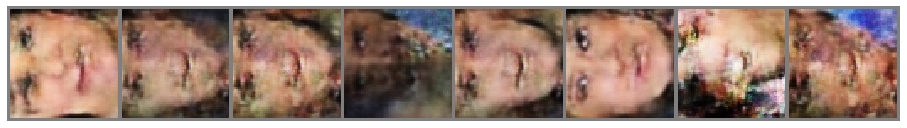

Epoch: 8
Batch:  0
1:Discriminator_Error:  1.5677974224090576  Generator_Error:  0.37747088074684143  Recons_Error:  0.08476037532091141
2:Feature Discriminator Error:  1.386157512664795 Encoder Error:  0.6950293183326721
3 Discriminator_adv_error 0.3046710193157196 Generator_error:  0.3026619553565979
Batch:  150
1:Discriminator_Error:  1.7065614461898804  Generator_Error:  0.3379485011100769  Recons_Error:  0.08528834581375122
2:Feature Discriminator Error:  1.38442063331604 Encoder Error:  0.699103593826294
3 Discriminator_adv_error 0.34448695182800293 Generator_error:  0.3243426978588104
Batch:  300
1:Discriminator_Error:  1.6695220470428467  Generator_Error:  0.3939015865325928  Recons_Error:  0.08325739204883575
2:Feature Discriminator Error:  1.38434898853302 Encoder Error:  0.6981742978096008
3 Discriminator_adv_error 0.3621160686016083 Generator_error:  0.3466590344905853
Batch:  450
1:Discriminator_Error:  1.5258618593215942  Generator_Error:  0.3919070065021515  Recons_Error

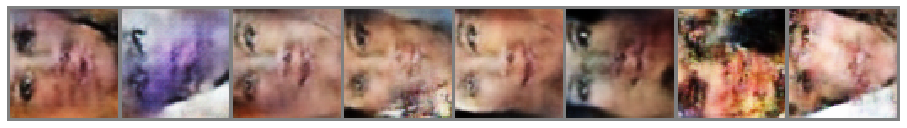

Epoch: 9
Batch:  0
1:Discriminator_Error:  1.501391053199768  Generator_Error:  0.5539100170135498  Recons_Error:  0.09078235924243927
2:Feature Discriminator Error:  1.3901543617248535 Encoder Error:  0.6981866359710693
3 Discriminator_adv_error 0.5773731470108032 Generator_error:  0.4353888928890228
Batch:  150
1:Discriminator_Error:  1.60028874874115  Generator_Error:  0.39721041917800903  Recons_Error:  0.08447973430156708
2:Feature Discriminator Error:  1.389309287071228 Encoder Error:  0.6941286325454712
3 Discriminator_adv_error 0.3094574809074402 Generator_error:  0.30165189504623413
Batch:  300
1:Discriminator_Error:  1.528254747390747  Generator_Error:  0.39175236225128174  Recons_Error:  0.088267982006073
2:Feature Discriminator Error:  1.3873028755187988 Encoder Error:  0.6931765079498291
3 Discriminator_adv_error 0.28723448514938354 Generator_error:  0.2801366448402405
Batch:  450
1:Discriminator_Error:  1.6437346935272217  Generator_Error:  0.34814590215682983  Recons_Err

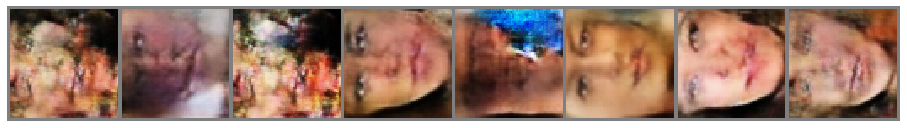

Epoch: 10
Batch:  0
1:Discriminator_Error:  1.6503233909606934  Generator_Error:  0.3471963107585907  Recons_Error:  0.08996599912643433
2:Feature Discriminator Error:  1.3842028379440308 Encoder Error:  0.6957852840423584
3 Discriminator_adv_error 0.3098749816417694 Generator_error:  0.30209270119667053
Batch:  150
1:Discriminator_Error:  1.6323444843292236  Generator_Error:  0.3633940517902374  Recons_Error:  0.09059036523103714
2:Feature Discriminator Error:  1.4001502990722656 Encoder Error:  0.6961197853088379
3 Discriminator_adv_error 0.3079151511192322 Generator_error:  0.3017968237400055
Batch:  300
1:Discriminator_Error:  1.5552985668182373  Generator_Error:  0.39536818861961365  Recons_Error:  0.08195427060127258
2:Feature Discriminator Error:  1.387340784072876 Encoder Error:  0.6983078718185425
3 Discriminator_adv_error 0.3044821321964264 Generator_error:  0.2950224280357361
Batch:  450
1:Discriminator_Error:  1.5186078548431396  Generator_Error:  0.6063485741615295  Recons

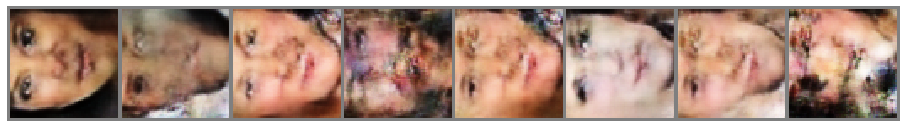

Epoch: 11
Batch:  0
1:Discriminator_Error:  1.5817034244537354  Generator_Error:  0.36230331659317017  Recons_Error:  0.08835487812757492
2:Feature Discriminator Error:  1.389868974685669 Encoder Error:  0.6902282238006592
3 Discriminator_adv_error 0.3169735372066498 Generator_error:  0.30776914954185486
Batch:  150
1:Discriminator_Error:  1.600907802581787  Generator_Error:  0.4025883376598358  Recons_Error:  0.08344621956348419
2:Feature Discriminator Error:  1.3892415761947632 Encoder Error:  0.6908810138702393
3 Discriminator_adv_error 0.3381754457950592 Generator_error:  0.334970623254776
Batch:  300
1:Discriminator_Error:  1.7256269454956055  Generator_Error:  0.3655989170074463  Recons_Error:  0.0839095413684845
2:Feature Discriminator Error:  1.3935165405273438 Encoder Error:  0.6963514089584351
3 Discriminator_adv_error 0.30172276496887207 Generator_error:  0.29123014211654663
Batch:  450
1:Discriminator_Error:  1.5866172313690186  Generator_Error:  0.3856912851333618  Recons_

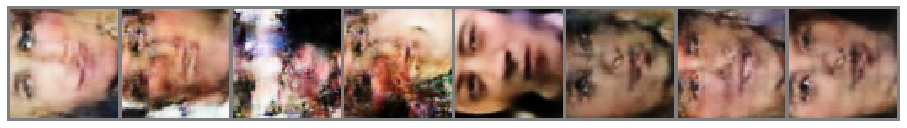

Epoch: 12
Batch:  0
1:Discriminator_Error:  1.6609078645706177  Generator_Error:  0.35023653507232666  Recons_Error:  0.08935984969139099
2:Feature Discriminator Error:  1.381507396697998 Encoder Error:  0.6964586973190308
3 Discriminator_adv_error 0.34228384494781494 Generator_error:  0.3301415741443634


In [ ]:
train(40,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load)